In [98]:
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

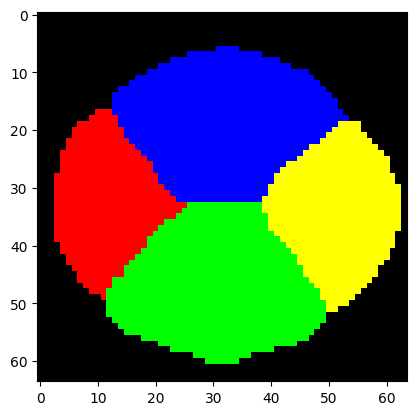

In [99]:
img = tifffile.imread(Path('~/workspace/data/four-cell/mask.tiff').expanduser())

plt.imshow(img)
plt.show()

In [100]:
def filter_by_color(image, rgb):
    binary_map = ((image[:, :, 0] == rgb[0]) & (image[:, :, 1] == rgb[1]) & (image[:, :, 2] == rgb[2]))
    return binary_map

In [101]:
cell_1 = filter_by_color(img, (255, 0, 0))
cell_2 = filter_by_color(img, (0, 255, 0))
cell_3 = filter_by_color(img, (0, 0, 255))
cell_4 = filter_by_color(img, (255, 255, 0))

In [102]:
def create_cell_overlap_mask(masks, dilation_iterations=1):
    dilated_masks = [ndimage.binary_dilation(mask, iterations=dilation_iterations) 
                     for mask in masks]
    
    overlap_map = np.zeros_like(masks[0], dtype=np.uint8)
    
    for i, mask in enumerate(dilated_masks):
        cell_value = 2 ** i
        overlap_map += mask.astype(np.uint8) * cell_value
    
    return overlap_map

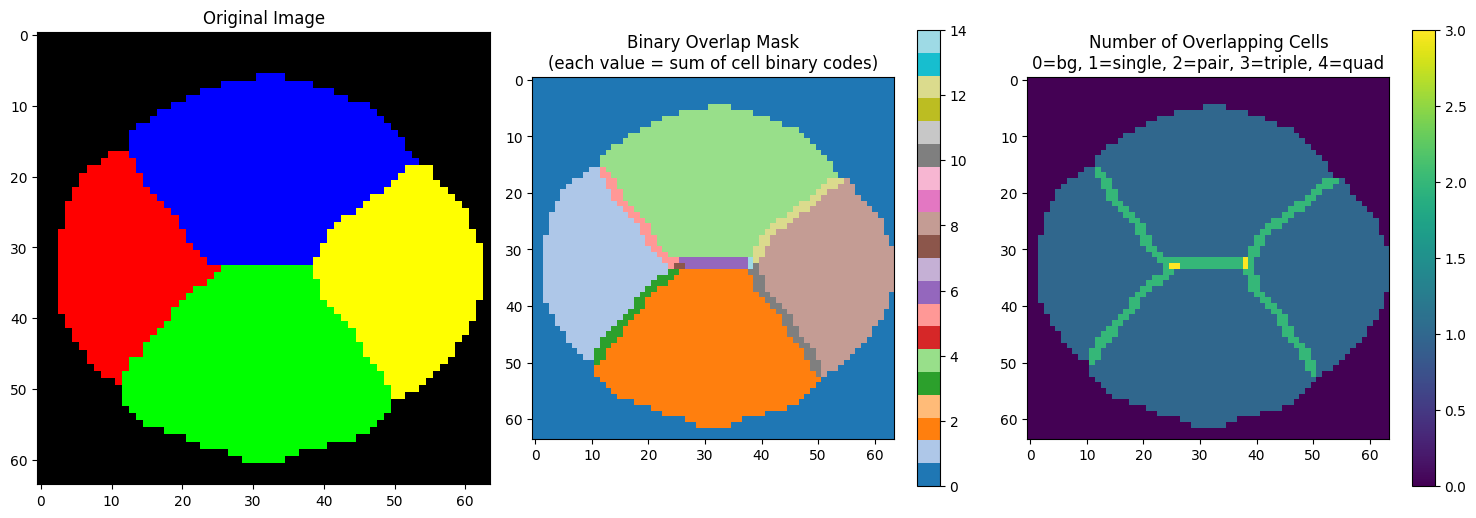

In [103]:
masks = [cell_1, cell_2, cell_3, cell_4]
overlap_mask = create_cell_overlap_mask(masks, dilation_iterations=1)

unique_values = np.unique(overlap_mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img[:, :, :3])
ax1.set_title('Original Image')

im2 = ax2.imshow(overlap_mask, cmap='tab20')
ax2.set_title('Binary Overlap Mask\n(each value = sum of cell binary codes)')
plt.colorbar(im2, ax=ax2)

overlap_count = np.zeros_like(overlap_mask, dtype=np.uint8)
for val in unique_values:
    if val > 0:
        num_cells = bin(val).count('1')
        overlap_count[overlap_mask == val] = num_cells

im3 = ax3.imshow(overlap_count, cmap='viridis')
ax3.set_title('Number of Overlapping Cells\n0=bg, 1=single, 2=pair, 3=triple, 4=quad')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()

In [104]:
from skimage.segmentation import find_boundaries
from skimage import graph
from skimage.measure import regionprops, label
import networkx as nx
from collections import defaultdict

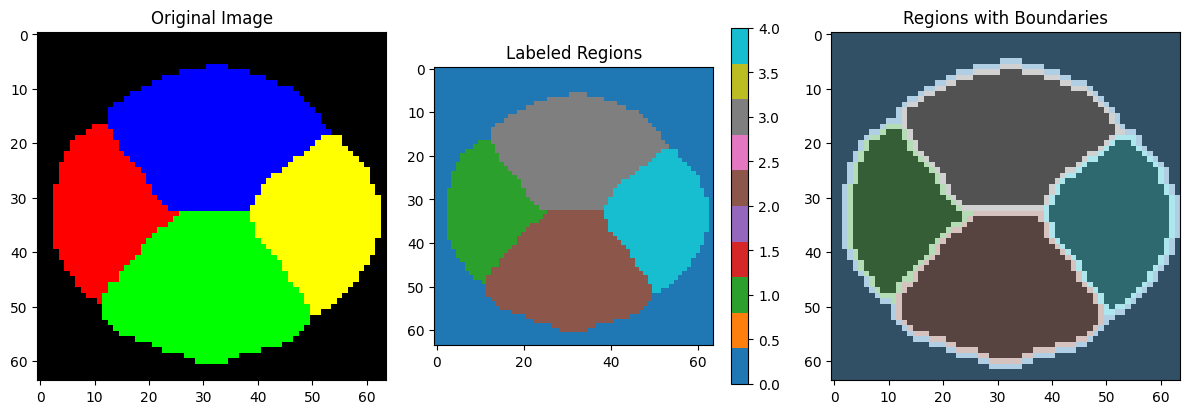

Number of regions: 4
Region labels: [1 2 3 4]


In [105]:
# Create a labeled image where each cell gets a unique label
labeled_image = np.zeros_like(cell_1, dtype=np.int32)

# Assign unique labels to each cell
labeled_image[cell_1] = 1  # Red cell
labeled_image[cell_2] = 2  # Green cell
labeled_image[cell_3] = 3  # Blue cell
labeled_image[cell_4] = 4  # Yellow cell

# Display the labeled image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img[:, :, :3])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(labeled_image, cmap='tab10')
plt.title('Labeled Regions')
plt.colorbar()

# Show region boundaries
boundaries = find_boundaries(labeled_image, mode='thick')
plt.subplot(1, 3, 3)
plt.imshow(labeled_image, cmap='tab10', alpha=0.7)
plt.imshow(boundaries, cmap='gray', alpha=0.5)
plt.title('Regions with Boundaries')

plt.tight_layout()
plt.show()

print(f"Number of regions: {len(np.unique(labeled_image)) - 1}")  # -1 to exclude background
print(f"Region labels: {np.unique(labeled_image)[1:]}")  # Exclude background (0)


In [106]:
def calculate_adjacency_length(labeled_image, region1_id, region2_id):
    """
    Calculate the length of the boundary between two adjacent regions.
    """
    # Create a mask where pixels are True if they are adjacent to both regions
    # Use a different approach: find pixels that are neighbors to both regions
    
    # Get the 4-connected neighbors of each region
    from scipy.ndimage import binary_dilation
    
    mask1 = (labeled_image == region1_id)
    mask2 = (labeled_image == region2_id)
    
    # Dilate each mask by 1 pixel to get neighboring areas
    dilated_mask1 = binary_dilation(mask1, structure=np.ones((3,3)))
    dilated_mask2 = binary_dilation(mask2, structure=np.ones((3,3)))
    
    # Find the interface: pixels that are in the dilation of one region
    # but belong to the other region
    interface1 = dilated_mask1 & mask2  # Pixels of region2 that touch region1
    interface2 = dilated_mask2 & mask1  # Pixels of region1 that touch region2
    
    # The total interface length is the sum of both interfaces
    # (they should be equal, but we'll take the average to be safe)
    length1 = np.sum(interface1)
    length2 = np.sum(interface2)
    
    # Return the average (they should be equal for a proper interface)
    adjacency_length = (length1 + length2) // 2
    
    return adjacency_length


In [107]:
# Build the Region Adjacency Graph (RAG)
rag = graph.rag_mean_color(img[:, :, :3], labeled_image)

print("Region Adjacency Graph:")
print(f"Number of nodes (regions): {rag.number_of_nodes()}")
print(f"Number of edges (adjacencies): {rag.number_of_edges()}")
print(f"Nodes: {list(rag.nodes())}")
print(f"Edges: {list(rag.edges())}")

# Remove background node (label 0) from the graph if it exists
if 0 in rag.nodes():
    rag.remove_node(0)
    print(f"\nAfter removing background node:")
    print(f"Number of nodes (regions): {rag.number_of_nodes()}")
    print(f"Number of edges (adjacencies): {rag.number_of_edges()}")
    print(f"Nodes: {list(rag.nodes())}")
    print(f"Edges: {list(rag.edges())}")

# Calculate adjacency lengths for all region pairs
adjacency_lengths = {}

for edge in rag.edges():
    region1, region2 = edge
    length = calculate_adjacency_length(labeled_image, region1, region2)
    adjacency_lengths[(region1, region2)] = length
    
    print(f"Adjacency length between region {region1} and region {region2}: {length} pixels")

# Also add the lengths as edge attributes to the graph
for edge in rag.edges():
    region1, region2 = edge
    rag[region1][region2]['adjacency_length'] = adjacency_lengths[(region1, region2)]


Region Adjacency Graph:
Number of nodes (regions): 5
Number of edges (adjacencies): 9
Nodes: [np.int64(0), np.int64(3), np.int64(1), np.int64(4), np.int64(2)]
Edges: [(np.int64(0), np.int64(3)), (np.int64(0), np.int64(1)), (np.int64(0), np.int64(4)), (np.int64(0), np.int64(2)), (np.int64(3), np.int64(1)), (np.int64(3), np.int64(4)), (np.int64(3), np.int64(2)), (np.int64(1), np.int64(2)), (np.int64(4), np.int64(2))]

After removing background node:
Number of nodes (regions): 4
Number of edges (adjacencies): 5
Nodes: [np.int64(3), np.int64(1), np.int64(4), np.int64(2)]
Edges: [(np.int64(3), np.int64(1)), (np.int64(3), np.int64(4)), (np.int64(3), np.int64(2)), (np.int64(1), np.int64(2)), (np.int64(4), np.int64(2))]
Adjacency length between region 3 and region 1: 30 pixels
Adjacency length between region 3 and region 4: 30 pixels
Adjacency length between region 3 and region 2: 13 pixels
Adjacency length between region 1 and region 2: 31 pixels
Adjacency length between region 4 and region 2

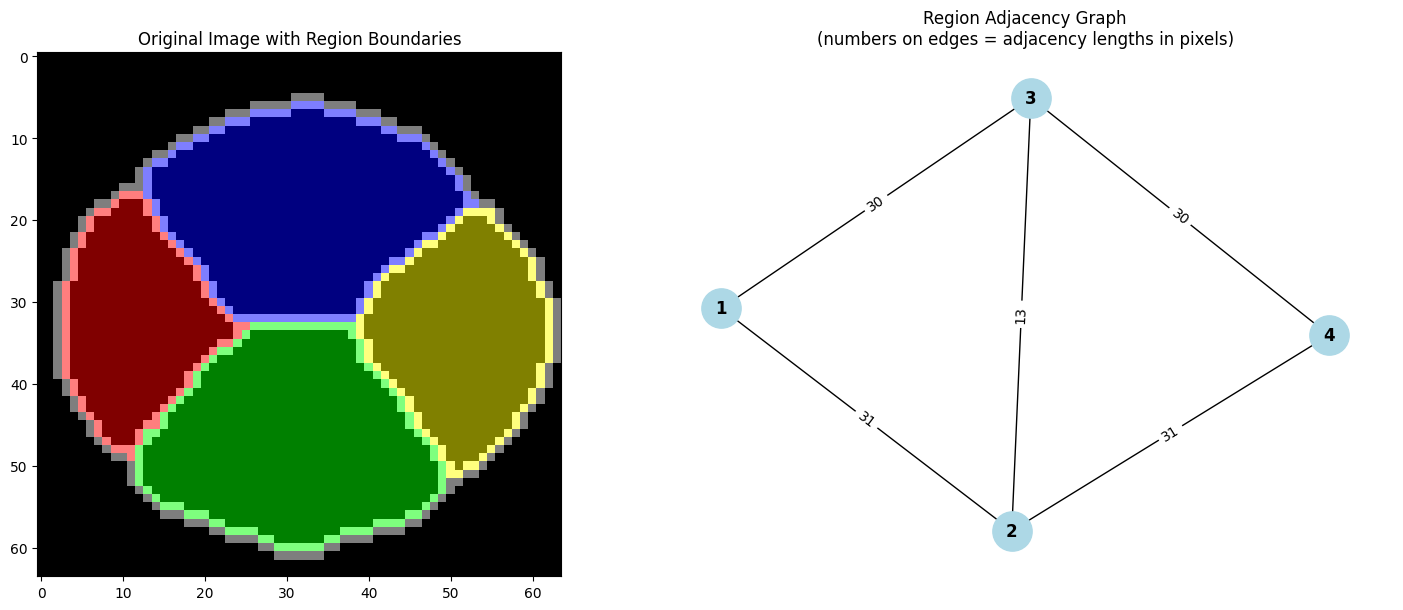

In [108]:
# Visualize the Region Adjacency Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Original image with region boundaries
ax1.imshow(img[:, :, :3])
boundaries = find_boundaries(labeled_image, mode='thick')
ax1.imshow(boundaries, cmap='gray', alpha=0.5)
ax1.set_title('Original Image with Region Boundaries')

# Right plot: RAG as a network graph
pos = {}
region_props = regionprops(labeled_image)

# Get centroids of regions for positioning nodes (exclude background)
for prop in region_props:
    region_id = prop.label
    if region_id != 0:  # Skip background
        centroid = prop.centroid
        pos[region_id] = (centroid[1], -centroid[0])  # Flip y-axis for proper orientation

# Draw the graph
nx.draw(rag, pos, ax=ax2, with_labels=True, node_color='lightblue', 
        node_size=800, font_size=12, font_weight='bold')

# Add edge labels with adjacency lengths
edge_labels = {edge: f"{adjacency_lengths[edge]}" for edge in rag.edges()}
nx.draw_networkx_edge_labels(rag, pos, edge_labels, ax=ax2, font_size=10)

ax2.set_title('Region Adjacency Graph\n(numbers on edges = adjacency lengths in pixels)')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()


In [109]:
# Create a summary table of adjacency lengths
import pandas as pd

# Create a comprehensive adjacency matrix
region_ids = list(range(1, 5))  # Regions 1, 2, 3, 4
adjacency_matrix = np.zeros((len(region_ids), len(region_ids)))

# Fill the adjacency matrix
for i, region1 in enumerate(region_ids):
    for j, region2 in enumerate(region_ids):
        if (region1, region2) in adjacency_lengths:
            adjacency_matrix[i, j] = adjacency_lengths[(region1, region2)]
        elif (region2, region1) in adjacency_lengths:
            adjacency_matrix[i, j] = adjacency_lengths[(region2, region1)]

# Create DataFrame for better visualization
df = pd.DataFrame(adjacency_matrix, 
                  index=[f'Region {i}' for i in region_ids],
                  columns=[f'Region {i}' for i in region_ids])

print("Adjacency Length Matrix (in pixels):")
print("Diagonal elements are 0 (self-adjacency)")
print("Matrix is symmetric (adjacency is bidirectional)")
print("\n", df)

# Show only the non-zero adjacencies
print("\nSummary of Adjacent Region Pairs:")
for edge, length in adjacency_lengths.items():
    region1, region2 = edge
    print(f"Region {region1} ↔ Region {region2}: {length} pixels")

# Calculate some statistics
total_boundary_length = sum(adjacency_lengths.values())
avg_boundary_length = np.mean(list(adjacency_lengths.values()))
max_boundary_length = max(adjacency_lengths.values())
min_boundary_length = min(adjacency_lengths.values())

print(f"\nBoundary Statistics:")
print(f"Total boundary length between all regions: {total_boundary_length} pixels")
print(f"Average boundary length: {avg_boundary_length:.1f} pixels")
print(f"Maximum boundary length: {max_boundary_length} pixels")
print(f"Minimum boundary length: {min_boundary_length} pixels")


Adjacency Length Matrix (in pixels):
Diagonal elements are 0 (self-adjacency)
Matrix is symmetric (adjacency is bidirectional)

           Region 1  Region 2  Region 3  Region 4
Region 1       0.0      31.0      30.0       0.0
Region 2      31.0       0.0      13.0      31.0
Region 3      30.0      13.0       0.0      30.0
Region 4       0.0      31.0      30.0       0.0

Summary of Adjacent Region Pairs:
Region 3 ↔ Region 1: 30 pixels
Region 3 ↔ Region 4: 30 pixels
Region 3 ↔ Region 2: 13 pixels
Region 1 ↔ Region 2: 31 pixels
Region 4 ↔ Region 2: 31 pixels

Boundary Statistics:
Total boundary length between all regions: 135 pixels
Average boundary length: 27.0 pixels
Maximum boundary length: 31 pixels
Minimum boundary length: 13 pixels


In [110]:
# Analyze node degrees (number of neighbors for each region)
print("Node Degrees (Number of Neighbors):")
for node in rag.nodes():
    degree = rag.degree[node]
    print(f"Region {node}: {degree} neighbors")

# Keep only nodes with 3 neighbors, remove the rest
nodes_with_3_neighbors = [node for node in rag.nodes() if rag.degree[node] == 3]
nodes_to_remove = [node for node in rag.nodes() if rag.degree[node] != 3]

print(f"\nNodes with 3 neighbors to keep: {nodes_with_3_neighbors}")
print(f"Nodes with fewer than 3 neighbors to be removed: {nodes_to_remove}")

# Create a filtered copy of the graph (keeping only nodes with 3 neighbors)
filtered_rag = rag.copy()
filtered_rag.remove_nodes_from(nodes_to_remove)

print(f"\nFiltered Graph (keeping only nodes with 3 neighbors):")
print(f"Number of nodes: {filtered_rag.number_of_nodes()}")
print(f"Number of edges: {filtered_rag.number_of_edges()}")
print(f"Remaining nodes: {list(filtered_rag.nodes())}")
print(f"Remaining edges: {list(filtered_rag.edges())}")

# Update adjacency lengths dictionary for filtered graph
filtered_adjacency_lengths = {edge: adjacency_lengths[edge] for edge in filtered_rag.edges() if edge in adjacency_lengths}

print(f"\nAdjacency lengths between regions with 3 neighbors:")
for edge, length in filtered_adjacency_lengths.items():
    region1, region2 = edge
    print(f"Region {region1} ↔ Region {region2}: {length} pixels")


Node Degrees (Number of Neighbors):
Region 3: 3 neighbors
Region 1: 2 neighbors
Region 4: 2 neighbors
Region 2: 3 neighbors

Nodes with 3 neighbors to keep: [np.int64(3), np.int64(2)]
Nodes with fewer than 3 neighbors to be removed: [np.int64(1), np.int64(4)]

Filtered Graph (keeping only nodes with 3 neighbors):
Number of nodes: 2
Number of edges: 1
Remaining nodes: [np.int64(3), np.int64(2)]
Remaining edges: [(np.int64(3), np.int64(2))]

Adjacency lengths between regions with 3 neighbors:
Region 3 ↔ Region 2: 13 pixels


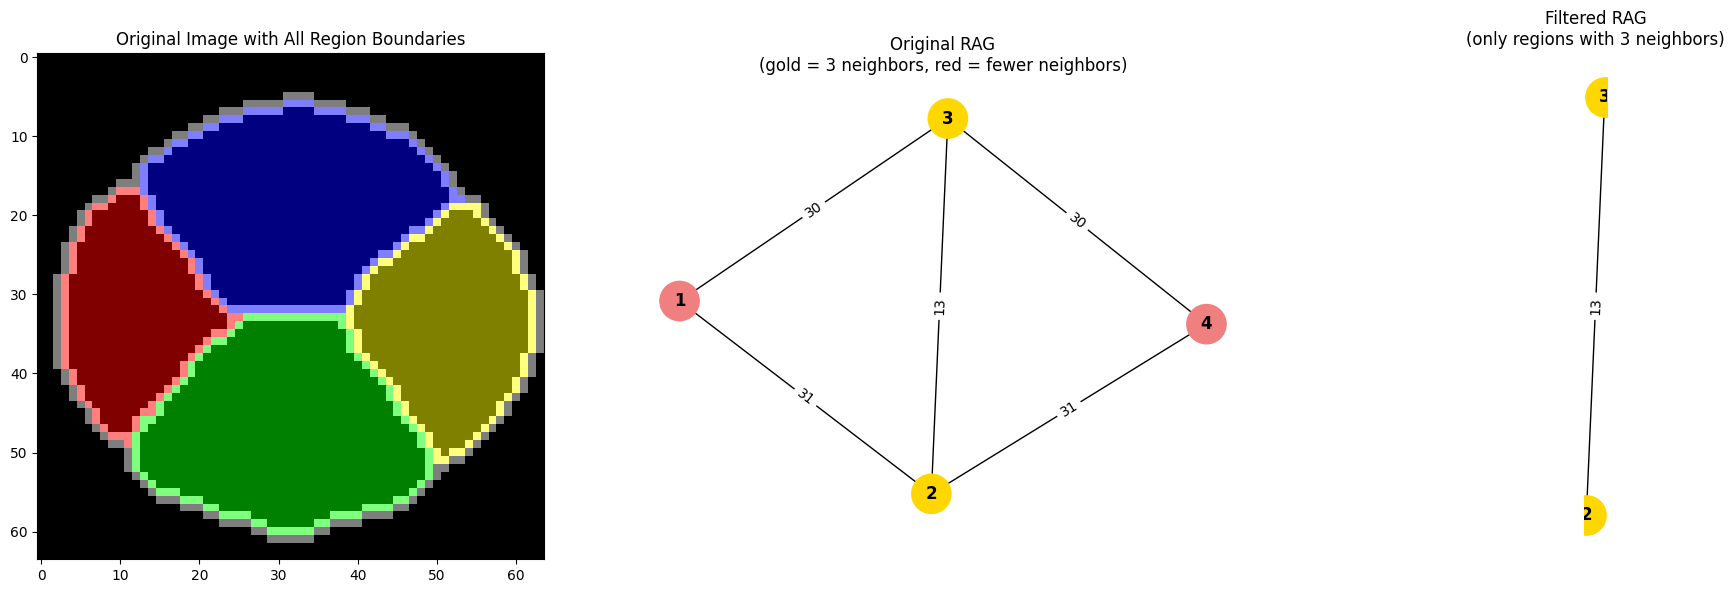

In [111]:
# Visualize the filtered Region Adjacency Graph
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Left plot: Original image with all region boundaries
ax1.imshow(img[:, :, :3])
boundaries = find_boundaries(labeled_image, mode='thick')
ax1.imshow(boundaries, cmap='gray', alpha=0.5)
ax1.set_title('Original Image with All Region Boundaries')

# Middle plot: Original RAG (before filtering)
pos = {}
region_props = regionprops(labeled_image)

# Get centroids of regions for positioning nodes (exclude background)
for prop in region_props:
    region_id = prop.label
    if region_id != 0:  # Skip background
        centroid = prop.centroid
        pos[region_id] = (centroid[1], -centroid[0])  # Flip y-axis for proper orientation

# Draw the original graph with different colors for nodes with 3 neighbors
node_colors = ['gold' if rag.degree[node] == 3 else 'lightcoral' for node in rag.nodes()]
nx.draw(rag, pos, ax=ax2, with_labels=True, node_color=node_colors, 
        node_size=800, font_size=12, font_weight='bold')

# Add edge labels with adjacency lengths
edge_labels = {edge: f"{adjacency_lengths[edge]}" for edge in rag.edges()}
nx.draw_networkx_edge_labels(rag, pos, edge_labels, ax=ax2, font_size=10)
ax2.set_title('Original RAG\n(gold = 3 neighbors, red = fewer neighbors)')
ax2.set_aspect('equal')

# Right plot: Filtered RAG (keeping only nodes with 3 neighbors)
filtered_pos = {node: pos[node] for node in filtered_rag.nodes() if node in pos}

nx.draw(filtered_rag, filtered_pos, ax=ax3, with_labels=True, node_color='gold', 
        node_size=800, font_size=12, font_weight='bold')

# Add edge labels with adjacency lengths for filtered graph
filtered_edge_labels = {edge: f"{filtered_adjacency_lengths[edge]}" for edge in filtered_rag.edges()}
nx.draw_networkx_edge_labels(filtered_rag, filtered_pos, filtered_edge_labels, ax=ax3, font_size=10)
ax3.set_title('Filtered RAG\n(only regions with 3 neighbors)')
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()


In [112]:
# Create updated summary table for the filtered graph (regions with 3 neighbors)
import pandas as pd

# Get the remaining region IDs after filtering
remaining_regions = list(filtered_rag.nodes())
remaining_regions.sort()

print(f"Summary after filtering:")
print(f"Kept regions with 3 neighbors: {nodes_with_3_neighbors}")
print(f"Removed regions with fewer than 3 neighbors: {nodes_to_remove}")
print(f"Remaining regions: {remaining_regions}")

if len(remaining_regions) > 0:
    # Create adjacency matrix for filtered graph
    filtered_adjacency_matrix = np.zeros((len(remaining_regions), len(remaining_regions)))

    # Fill the adjacency matrix
    region_to_index = {region: i for i, region in enumerate(remaining_regions)}
    
    for edge, length in filtered_adjacency_lengths.items():
        region1, region2 = edge
        i = region_to_index[region1]
        j = region_to_index[region2]
        filtered_adjacency_matrix[i, j] = length
        filtered_adjacency_matrix[j, i] = length  # Make symmetric

    # Create DataFrame for better visualization
    filtered_df = pd.DataFrame(filtered_adjacency_matrix, 
                              index=[f'Region {i}' for i in remaining_regions],
                              columns=[f'Region {i}' for i in remaining_regions])

    print("\nAdjacency Length Matrix for Regions with 3 Neighbors (in pixels):")
    print(filtered_df)

    # Calculate statistics for filtered graph
    if len(filtered_adjacency_lengths) > 0:
        total_boundary_length = sum(filtered_adjacency_lengths.values())
        avg_boundary_length = np.mean(list(filtered_adjacency_lengths.values()))
        max_boundary_length = max(filtered_adjacency_lengths.values())
        min_boundary_length = min(filtered_adjacency_lengths.values())

        print(f"\nStatistics for Regions with 3 Neighbors:")
        print(f"Total boundary length between these regions: {total_boundary_length} pixels")
        print(f"Average boundary length: {avg_boundary_length:.1f} pixels")
        print(f"Maximum boundary length: {max_boundary_length} pixels")
        print(f"Minimum boundary length: {min_boundary_length} pixels")
        
        # Show individual adjacency lengths
        print(f"\nDetailed adjacency lengths between regions with 3 neighbors:")
        for edge, length in filtered_adjacency_lengths.items():
            region1, region2 = edge
            print(f"  Region {region1} ↔ Region {region2}: {length} pixels")
    else:
        print("\nNo adjacencies exist between the regions with 3 neighbors.")
else:
    print("\nNo regions with 3 neighbors found.")


Summary after filtering:
Kept regions with 3 neighbors: [np.int64(3), np.int64(2)]
Removed regions with fewer than 3 neighbors: [np.int64(1), np.int64(4)]
Remaining regions: [np.int64(2), np.int64(3)]

Adjacency Length Matrix for Regions with 3 Neighbors (in pixels):
          Region 2  Region 3
Region 2       0.0      13.0
Region 3      13.0       0.0

Statistics for Regions with 3 Neighbors:
Total boundary length between these regions: 13 pixels
Average boundary length: 13.0 pixels
Maximum boundary length: 13 pixels
Minimum boundary length: 13 pixels

Detailed adjacency lengths between regions with 3 neighbors:
  Region 3 ↔ Region 2: 13 pixels


In [ ]:
# Let's also create a visualization to show how the boundary length is calculated
def visualize_boundary_calculation(labeled_image, region1_id, region2_id):
    """
    Visualize how the boundary length is calculated between two regions.
    """
    mask1 = (labeled_image == region1_id)
    mask2 = (labeled_image == region2_id)
    
    # Create a binary image where only the two regions of interest are marked
    binary_regions = (mask1.astype(int) + mask2.astype(int) * 2)
    
    # Create an image to show the boundary segments
    boundary_image = np.zeros_like(labeled_image, dtype=float)
    rows, cols = labeled_image.shape
    
    # Mark horizontal boundaries
    for i in range(rows):
        for j in range(cols - 1):
            val1 = binary_regions[i, j]
            val2 = binary_regions[i, j + 1]
            if (val1 == 1 and val2 == 2) or (val1 == 2 and val2 == 1):
                # Mark both adjacent pixels to show the boundary
                boundary_image[i, j] = 0.5
                boundary_image[i, j + 1] = 0.5
    
    # Mark vertical boundaries
    for i in range(rows - 1):
        for j in range(cols):
            val1 = binary_regions[i, j]
            val2 = binary_regions[i + 1, j]
            if (val1 == 1 and val2 == 2) or (val1 == 2 and val2 == 1):
                # Mark both adjacent pixels to show the boundary
                boundary_image[i, j] = 0.5
                boundary_image[i + 1, j] = 0.5
    
    return binary_regions, boundary_image

# Show boundary calculation for one example pair
if len(rag.edges()) > 0:
    example_edge = list(rag.edges())[0]
    region1, region2 = example_edge
    
    binary_regions, boundary_vis = visualize_boundary_calculation(labeled_image, region1, region2)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original regions
    ax1.imshow(labeled_image, cmap='tab10')
    ax1.set_title(f'All Regions')
    
    # Two regions of interest
    ax2.imshow(binary_regions, cmap='viridis')
    ax2.set_title(f'Region {region1} (yellow) & Region {region2} (purple)')
    
    # Boundary visualization
    display_image = np.zeros((labeled_image.shape[0], labeled_image.shape[1], 3))
    display_image[binary_regions == 1] = [1, 1, 0]  # Yellow for region1
    display_image[binary_regions == 2] = [0.5, 0, 0.5]  # Purple for region2
    display_image[boundary_vis > 0] = [1, 0, 0]  # Red for boundary pixels
    
    ax3.imshow(display_image)
    ax3.set_title(f'Boundary Segments (red)\nLength: {adjacency_lengths[example_edge]} units')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Boundary calculation explanation:")
    print(f"- The length is calculated by counting boundary SEGMENTS, not pixels")
    print(f"- Each segment is the edge between two adjacent pixels from different regions")
    print(f"- Horizontal segments: transitions between left-right adjacent pixels")
    print(f"- Vertical segments: transitions between up-down adjacent pixels")
    print(f"- This gives the true perimeter length without thickness")
